## Import libraries and data

In [21]:
%run load_data.py

/anaconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py:761: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exit_ignore=exit_ignore)


## Plot loan grade distributions

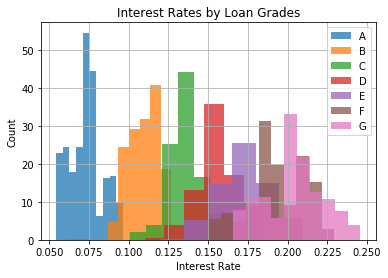

In [22]:
# Plot distribution of interest rates for each loan grade

for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    subset = frame['grade'] == grade
    frame['int_rate_num'][subset].hist(label = grade, normed = True, alpha = 0.75)

plt.legend()
plt.title("Interest Rates by Loan Grades")
plt.ylabel("Count")
plt.xlabel("Interest Rate")
plt.savefig("interestratehistogram.png", dpi=200)
plt.show()

## Logistic Regression

In [23]:
# Logistic regression of probability of going bad on pre-application characteristics

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, train_labels["bad"])
test_features['pred_fail_rate'] = lr.predict_proba(test_features)[:, 1]

## Linear regression

In [24]:
from sklearn import linear_model

linreg = linear_model.LinearRegression()
linreg.fit(train_features, train_labels["bad"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
import statsmodels.api as sm
linregCO = sm.OLS(train_labels["bad"], sm.add_constant(train_features)).fit()
linregCO.summary()

## Explore returns

In [ ]:
linreg_ret = sm.OLS(train_labels["return"], sm.add_constant(train_features)).fit()
linreg_ret.summary()

In [ ]:
linreg_rec = sm.OLS(train_labels[train_labels.bad == 0]["return"], 
                    sm.add_constant(train_features[train_labels.bad == 0])).fit()
linreg_rec.summary()

In [ ]:
linreg_rec_rate = sm.OLS(train_labels[train_labels.bad == 1]["return"], 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate.summary()
test_features["pred_rec_rate"] = linreg_rec_rate.predict(test_features.drop("pred_fail_rate", 1))

In [29]:
np.corrcoef(test_features[["pred_fail_rate", "pred_rec_rate"]], rowvar=0)

array([[ 1.        , -0.17419685],
       [-0.17419685,  1.        ]])

In [30]:
# Compute expected gross return R

test_features["exp_R"] = ((1 + test_features["int_rate_num"]) * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate"] * test_features["pred_fail_rate"])

## Are cross moments predictable?

In [31]:
features1 = train_features.iloc[:1000, :20].copy()
labels1 = train_labels.iloc[:1000, :20].copy()
features2 = train_features.iloc[1000:2000, :20].copy()
labels2 = train_labels.iloc[1000:2000, :20].copy()

## Predicting variances

In [ ]:
linreg_rec_rate2 = sm.OLS(train_labels[train_labels.bad == 1]["return"] ** 2, 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate2.summary()
test_features["pred_rec_rate2"] = linreg_rec_rate2.predict(sm.add_constant(test_features.iloc[:,:107]))

test_features["var_R"] = ((1 + test_features["int_rate_num"])**2 * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate2"] * test_features["pred_fail_rate"] 
                         - test_features["exp_R"]**2)

## Skewness

In [ ]:
linreg_rec_rate3 = sm.OLS(train_labels[train_labels.bad == 1]["return"] ** 3, 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate3.summary()

test_features["pred_rec_rate3"] = linreg_rec_rate3.predict(test_features.iloc[:, :107])

test_features["exp_R3"] = ((1 + test_features["int_rate_num"])**3 * (1 - test_features["pred_fail_rate"]) +
                           test_features["pred_rec_rate3"] * test_features["pred_fail_rate"])

test_features.eval("skew_R = (exp_R3 - 3 * exp_R * var_R - exp_R ** 3)", inplace=True)

In [ ]:
sm.OLS(grades["grade_A"], sm.add_constant(test_features[["var_R", "skew_R"]])).fit(cov_type='HC0').summary()

In [ ]:
import statsmodels.stats.outliers_influence

statsmodels.stats.outliers_influence.variance_inflation_factor(test_features[["var_R", "skew_R"]].values, 1)

## Separate Regressions for Each Loan Grade

In [ ]:
# Regressions of rates on personal characteristics

from sklearn.linear_model import LogisticRegression

train_features_no_int = train_features.iloc[:, :107].drop("int_rate_num", 1)
test_features_no_int = test_features.iloc[:, :107].drop("int_rate_num", 1)

for grade in ["A", "B", "C", "D", "E", "F", "G"]: 
    
    lr_fail_rate = LogisticRegression()
    lr_fail_rate.fit(train_features_no_int[train_labels["grade_" + grade] == 1], 
                     train_labels[train_labels["grade_" + grade] == 1]["bad"])
    test_features["pred_fail_rate_" + grade] = lr_fail_rate.predict_proba(test_features_no_int)[:, 1]
    
    mask = (train_labels["grade_" + grade] == 1) & (train_labels["bad"] == 1)
    lr_rec_rate = sm.OLS(train_labels[mask]["return"], sm.add_constant(train_features_no_int[mask])).fit()
    test_features["pred_rec_rate_" + grade] = lr_rec_rate.predict(test_features_no_int)
    
    lr_rec_rate2 = sm.OLS(train_labels[mask]["return"] ** 2, sm.add_constant(train_features_no_int[mask])).fit()
    test_features["pred_rec_rate2_" + grade] = lr_rec_rate2.predict(test_features_no_int)
    
    r = np.mean(train_features[train_labels["grade_" + grade] == 1]["int_rate_num"])
    
    test_features["exp_R_" + grade] = ((1 + r) * (1 - test_features["pred_fail_rate_" + grade]) +
                         test_features["pred_rec_rate_" + grade] * test_features["pred_fail_rate_" + grade])
    
    test_features["var_R_" + grade] = ((1 + r)**2 * (1 - test_features["pred_fail_rate_" + grade]) +
                         test_features["pred_rec_rate2_" + grade] * test_features["pred_fail_rate_" + grade] 
                         - test_features["exp_R_" + grade]**2)

In [ ]:
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
    plt.plot(test_features[test_labels["grade_" + grade] == 1]["exp_R_" + grade], 
             test_features[test_labels["grade_" + grade] == 1]["var_R_" + grade], 
             marker='o', linestyle='', label=grade, alpha = 0.25)

plt.legend()
plt.title("Loans by Estimated Return and Variance")
plt.xlabel("Return")
plt.ylabel("Variance")
fig1 = plt.gcf()
fig1.savefig('returnvariance.png', dpi=200)
plt.show()

## ML Discrete Choice Model

In [53]:
# Define negative log-likelihood function

def nllh(beta, features, labels):
    utilities = {}
    for grade in ["A", "B", "C", "D", "E", "F", "G"]:
        utilities[grade] = np.dot(features[["exp_R_" + grade, "var_R_" + grade]].values, beta)
    utilitiesArray = pd.DataFrame(utilities).values
    indicatorArray = labels[["grade_" + x for x in ["A", "B", "C", "D", "E", "F", "G"]]].values
    term1 = np.sum(utilitiesArray * indicatorArray, axis=1)
    term2 = np.log(np.sum(np.exp(utilitiesArray), axis=1))
    return -1 * np.sum(term1 - term2)

def grad(beta, features, labels):
    X1, X2 = {}, {}
    utilities = {}
    for grade in ["A", "B", "C", "D", "E", "F", "G"]:
        X1[grade] = features["exp_R_" + grade].values
        X2[grade] = features["var_R_" + grade].values
        utilities[grade] = np.dot(features[["exp_R_" + grade, "var_R_" + grade]].values, beta)
    X1Array = pd.DataFrame(X1).values
    X2Array = pd.DataFrame(X2).values
    utilitiesArray = pd.DataFrame(utilities).values
        
    indicatorArray = labels[["grade_" + x for x in ["A", "B", "C", "D", "E", "F", "G"]]].values
    
    d1 = (np.sum(X1Array * indicatorArray, axis=1) - 
     np.sum(np.exp(utilitiesArray) * X1Array, axis=1) / np.sum(np.exp(utilitiesArray), axis=1))
    d2 = (np.sum(X2Array * indicatorArray, axis=1) - 
     np.sum(np.exp(utilitiesArray) * X2Array, axis=1) / np.sum(np.exp(utilitiesArray), axis=1))
    
    return -1 * np.array([np.sum(d1), np.sum(d2)])

def nllh_restriction1(beta, features, labels):
    utilities = {}
    for grade in ["A", "B", "C", "D", "E", "F", "G"]:
        utilities[grade] = features["var_R_" + grade].values * beta
    utilitiesArray = pd.DataFrame(utilities).values
    indicatorArray = labels[["grade_" + x for x in ["A", "B", "C", "D", "E", "F", "G"]]].values
    term1 = np.sum(utilitiesArray * indicatorArray, axis=1)
    term2 = np.log(np.sum(np.exp(utilitiesArray), axis=1))
    return -1 * np.sum(term1 - term2)

def nllh_restriction2(beta, features, labels):
    utilities = {}
    for grade in ["A", "B", "C", "D", "E", "F", "G"]:
        utilities[grade] = features["exp_R_" + grade].values * beta
    utilitiesArray = pd.DataFrame(utilities).values
    indicatorArray = labels[["grade_" + x for x in ["A", "B", "C", "D", "E", "F", "G"]]].values
    term1 = np.sum(utilitiesArray * indicatorArray, axis=1)
    term2 = np.log(np.sum(np.exp(utilitiesArray), axis=1))
    return -1 * np.sum(term1 - term2)

In [54]:
nllh([0,0], test_features, test_labels)

1491868.9880660886

In [50]:
# Run maximum likelihood estimation

import scipy.optimize

scipy.optimize.minimize(nllh, [0,0], jac=grad, args=(test_features, test_labels), method='BFGS')

      fun: 1322473.477544718
 hess_inv: array([[ 0.00825954, -0.00601519],
       [-0.00601519,  0.01381828]])
      jac: array([ -2.25960928e-09,  -3.28935007e-09])
  message: 'Optimization terminated successfully.'
     nfev: 35
      nit: 11
     njev: 33
   status: 0
  success: True
        x: array([  6.43002213, -53.826577  ])

In [57]:
# Likelihood ratio tests

llh_r = scipy.optimize.minimize(nllh_restriction1, [0], args=(test_features, test_labels), method='BFGS').fun
-2 * (1322473.477544718 - llh_r)

5063.53252073098

In [58]:
llh_r = scipy.optimize.minimize(nllh_restriction2, [0], args=(test_features, test_labels), method='BFGS').fun
-2 * (1322473.477544718 - llh_r)

278062.39080033684

## Polynomial regression

In [46]:
from sklearn.preprocessing import PolynomialFeatures

def predict_MLP(train_features, train_labels, test_features):
    train_features_no_int = train_features.iloc[:, :107].drop("int_rate_num", 1)
    test_features_no_int = test_features.iloc[:, :107].drop("int_rate_num", 1)

    for grade in ["A", "B", "C", "D", "E", "F", "G"]: 

        mlp_fail_rate = MLPRegressor()
        mlp_fail_rate.fit(train_features_no_int[train_labels["grade_" + grade] == 1], 
                          train_labels[train_labels["grade_" + grade] == 1]["bad"])
        test_features["MLP_pred_fail_rate_" + grade] = mlp_fail_rate.predict(test_features_no_int)

#         mask = (train_labels["grade_" + grade] == 1) & (train_labels["bad"] == 1)
#         lr_rec_rate = sm.OLS(train_labels[mask]["return"], sm.add_constant(train_features_no_int[mask])).fit()
#         test_features["pred_rec_rate_" + grade] = lr_rec_rate.predict(test_features_no_int)

#         lr_rec_rate2 = sm.OLS(train_labels[mask]["return"] ** 2, sm.add_constant(train_features_no_int[mask])).fit()
#         test_features["pred_rec_rate2_" + grade] = lr_rec_rate2.predict(test_features_no_int)

#         r = np.mean(train_features[train_labels["grade_" + grade] == 1]["int_rate_num"])

#         test_features["exp_R_" + grade] = ((1 + r) * (1 - test_features["pred_fail_rate_" + grade]) +
#                              test_features["pred_rec_rate_" + grade] * test_features["pred_fail_rate_" + grade])

#         test_features["var_R_" + grade] = ((1 + r)**2 * (1 - test_features["pred_fail_rate_" + grade]) +
#                              test_features["pred_rec_rate2_" + grade] * test_features["pred_fail_rate_" + grade] 
#                              - test_features["exp_R_" + grade]**2)
    return

PolynomialFeatures().fit_transform(train_features.head())

array([[  1.00000000e+00,   2.20000000e+04,   7.60000000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   4.00000000e+03,   6.40000000e+04, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.05000000e+04,   3.10000000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   3.50000000e+04,   1.46000000e+05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   5.00000000e+03,   2.63900000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

## Bootstrap

In [ ]:
#Bootstrapping standard errors

from sklearn.utils import resample

iterations = 5
size = int(len())



for i in range(iterations):
    # sample data
    #boostrapping the training data
    
    bs_train_features = resample(train_features, n_samples = len(train_features))
    bs_train_labels = resample(train_labels, n_samples = len(train_labels))
    
    #bs_test_features = resample(test_features, n_samples = len(test_features))
    #bs_test_labels = resample(test_labels, n_samples = len(test_features))
    

    #creating predicted fail rate
    lr = LogisticRegression()
    lr.fit(bs_train_features, bs_train_labels["bad"])
    test_features['pred_fail_rate'] = lr.predict_proba(bs_test_features)[:, 1]
    
    
    #predicted recovery rate and expected return and variance
    linreg_rec_rate = sm.OLS(bs_train_labels[bs_train_labels.bad == 1]["return"], 
                         sm.add_constant(bs_train_features[bs_train_labels.bad == 1])).fit()
    linreg_rec_rate.summary()
    test_features["pred_rec_rate"] = linreg_rec_rate.predict(test_features.drop("pred_fail_rate", 1))
    
    test_features["exp_R"] = ((1 + test_features["int_rate_num"]) * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate"] * test_features["pred_fail_rate"])
    
    linreg_rec_rate2 = sm.OLS(bs_train_labels[bs_train_labels.bad == 1]["return"] ** 2, 
                         sm.add_constant(bs_train_features[bs_train_labels.bad == 1])).fit()
    linreg_rec_rate2.summary()
    test_features["pred_rec_rate2"] = linreg_rec_rate2.predict(sm.add_constant(test_features.iloc[:,:107]))

    test_features["var_R"] = ((1 + test_features["int_rate_num"])**2 * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate2"] * test_features["pred_fail_rate"] 
                         - test_features["exp_R"]**2)
    
    
    #expected return and variance by grade
    bs_train_features_no_int = bs_train_features.iloc[:, :107].drop("int_rate_num", 1)
    test_features_no_int = test_features.iloc[:, :107].drop("int_rate_num", 1)

    for grade in ["A", "B", "C", "D", "E", "F", "G"]: 
    
        lr_fail_rate = LogisticRegression()
        lr_fail_rate.fit(bs_train_features_no_int[bs_train_labels["grade_" + grade] == 1], 
                     bs_train_labels[bs_train_labels["grade_" + grade] == 1]["bad"])
        test_features["pred_fail_rate_" + grade] = lr_fail_rate.predict_proba(test_features_no_int)[:, 1]
    
        mask = (bs_train_labels["grade_" + grade] == 1) & (bs_train_labels["bad"] == 1)
        lr_rec_rate = sm.OLS(bs_train_labels[mask]["return"], sm.add_constant(bs_train_features_no_int[mask])).fit()
        test_features["pred_rec_rate_" + grade] = lr_rec_rate.predict(test_features_no_int)
    
        lr_rec_rate2 = sm.OLS(bs_train_labels[mask]["return"] ** 2, sm.add_constant(bs_train_features_no_int[mask])).fit()
        test_features["pred_rec_rate2_" + grade] = lr_rec_rate2.predict(test_features_no_int)
    
        r = np.mean(bs_train_features[bs_train_labels["grade_" + grade] == 1]["int_rate_num"])
    
        test_features["exp_R_" + grade] = ((1 + r) * (1 - test_features["pred_fail_rate_" + grade]) +
                         test_features["pred_rec_rate_" + grade] * test_features["pred_fail_rate_" + grade])
    
        test_features["var_R_" + grade] = ((1 + r)**2 * (1 - test_features["pred_fail_rate_" + grade]) +
                        test_features["pred_rec_rate2_" + grade] * test_features["pred_fail_rate_" + grade] 
                         - test_features["exp_R_" + grade]**2)
    
    #bootstrapping test_data
    bs_test_features = resample(test_features, n_samples = len(test_features))
    bs_test_labels = resample(test_labels, n_samples = len(test_labels))
    
    
    results = scipy.optimize.minimize(nllh, [0,0,0], args=(bs_test_features, bs_test_labels), method='Nelder-Mead')['x']
    # getting betas
    b1.append(results[0])
    b2.append(results[1])
    b3.append(results[2])

#standard errors
se_b1 = np.std(b1)
se_b2 = np.std(b2)
se_b3 = np.std(b3)

## Marginal Effects

In [38]:
#getting the MLE utility array \beta' x using the estimated betas from the estimation

est_betas = np.array([6.43002213, -53.826577])
utilities = {}
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
utilities[grade] = np.dot(features[["exp_R_" + grade, "var_R_" + grade]].values, est_betas)
est_utilitiesArray = pd.DataFrame(utilities).values


#defining the CDF of the logistic distribution

def lambda_(x):
    res = np.exp(x)/(1+exp(x))
    return(res)
    
#logistic density function (derivative of logistic CDF)

def gamma(x):
    res = lambda_(x)/(1-lambda_(x))
    return(res)

#marginal effect is the logistic density fucntion times the beta 
#should return an array of the marginal change in the expected probability given a feature ∂E(y|x)/∂x

def marginal_effect(x):
    res = np.dot(gamma(x), est_betas)
    return(res)

## How well does the mean variance paradigm perform out of sample?

In [ ]:
#predict utilities of assigning a given loan to a grade, run the matching algorithm then compare results

In [161]:
%run load_oos_data.py

/anaconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py:761: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exit_ignore=exit_ignore)


In [162]:
# Regressions of rates on personal characteristics

from sklearn.linear_model import LogisticRegression

features_no_int = features.iloc[:, :107].drop("int_rate_num", 1)

In [163]:
for grade in ["A", "B", "C", "D", "E", "F", "G"]: 
    
    lr_fail_rate = LogisticRegression()
    lr_fail_rate.fit(features_no_int[labels["grade_" + grade] == 1], 
                     labels[labels["grade_" + grade] == 1]["bad"])
    features["pred_fail_rate_" + grade] = lr_fail_rate.predict_proba(features_no_int)[:, 1]
    
    mask = (labels["grade_" + grade] == 1) & (labels["bad"] == 1)
    
    lr_rec_rate = sm.OLS(labels[mask]["return"], sm.add_constant(features_no_int[mask])).fit()
    features["pred_rec_rate_" + grade] = lr_rec_rate.predict(features_no_int)
    
    lr_rec_rate2 = sm.OLS(labels[mask]["return"] ** 2, sm.add_constant(features_no_int[mask])).fit()
    features["pred_rec_rate2_" + grade] = lr_rec_rate2.predict(features_no_int)
    
    r = np.mean(features[labels["grade_" + grade] == 1]["int_rate_num"])
    
    features["exp_R_" + grade] = ((1 + r) * (1 - features["pred_fail_rate_" + grade]) +
                         features["pred_rec_rate_" + grade] * features["pred_fail_rate_" + grade])
    
    features["var_R_" + grade] = ((1 + r)**2 * (1 - features["pred_fail_rate_" + grade]) +
                         features["pred_rec_rate2_" + grade] * features["pred_fail_rate_" + grade] 
                         - features["exp_R_" + grade]**2)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


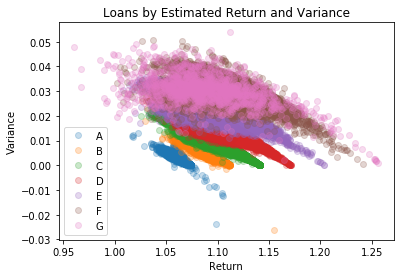

In [164]:
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
    plt.plot(features[labels["grade_" + grade] == 1]["exp_R_" + grade], 
             features[labels["grade_" + grade] == 1]["var_R_" + grade], 
             marker='o', linestyle='', label=grade, alpha = 0.25)

plt.legend()
plt.title("Loans by Estimated Return and Variance")
plt.xlabel("Return")
plt.ylabel("Variance")
fig1 = plt.gcf()
fig1.savefig('returnvariance.png', dpi=200)
plt.show()

In [165]:
est_betas = np.array([6.43002213, -53.826577])
utilities = {}
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
    utilities[grade] = np.dot(features[["exp_R_" + grade, "var_R_" + grade]].values, est_betas)
    est_utilitiesFrame = pd.DataFrame(utilities)

In [166]:
#final step I gotta run the matching algo
cap = pd.DataFrame([0])
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
    cap[grade] = np.sum(labels['grade_' + grade])

In [167]:
from IPython import display

In [168]:
#matching algo
def matching_algorithm(data, capacities):
    grade_list = ["A", "B", "C", "D", "E", "F", "G"]   
    for i in range(len(data)):
        m = max(est_utilitiesFrame[grade_list].iloc[i])
        for grade in grade_list:
            if est_utilitiesFrame[grade][i] == m: 
                data.iloc[i] = 0
                data[grade][i] = 1
            
            if sum(est_utilitiesFrame[grade].loc[est_utilitiesFrame[grade] == 1.0]) == capacities[grade].values:
                grade_list.remove(grade) 
        
        print(str(i) + ' matched')
        display.clear_output(wait=False)
    return(data)


final_matching = matching_algorithm(est_utilitiesFrame, cap)

In [179]:
#finding mathcing values between mathcing algo output and real matches
l = []
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
    a = final_matching.loc[final_matching[grade] == 1].index.tolist()
    b = labels.loc[labels['grade_'+grade] == 1].index.tolist()
    res = (len(set(a).intersection(b)))/len(b)*100
    l.append('return and variance predict ' + str(res)[:4] + ' % of matches for grade ' + grade)

l

['return and variance predict 17.2 % of matches for grade A',
 'return and variance predict 23.3 % of matches for grade B',
 'return and variance predict 25.4 % of matches for grade C',
 'return and variance predict 16.2 % of matches for grade D',
 'return and variance predict 6.73 % of matches for grade E',
 'return and variance predict 2.62 % of matches for grade F',
 'return and variance predict 0.14 % of matches for grade G']

In [180]:
final_matching.to_csv('final_matching.csv')